In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn import linear_model
from scipy import stats
from statsmodels.api import add_constant
from pandas.core import datetools
%matplotlib inline

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
month = {'JAN': 1, 'FEB':2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6, 'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT':10, 'NOV': 11, 'DEC': 12}

In [4]:
DJIA_company_list = ['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'DWDP', 'GE', 'GS', \
                           'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', \
                            'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'V', 'VZ', 'WMT', 'XOM' ]

In [6]:
company_list = ['VAC', 'UNF', 'TREX', 'STMP', 'SIGI', 'QLYS', 'PSB', 'PRLB', 'PDCE', 'NSP',\
                            'NEOG', 'MOGA', 'LGND', 'KS', 'KFY', 'JBT', 'IART', 'HI', 'HAE', 'GDOT', \
                            'GBCI', 'FIVE', 'FFIN', 'FCFS', 'COLB', 'CHE', 'CACI', 'B', 'AVA']

In [8]:
# Import high frequency data
def import_data(path, company_list):
    path = path               #r'D:\data_raw' # Please put all .csv documents into one folder
    company_list = company_list# Input company name as a list
    company_data = {} # Store company data as a dictionary: {company_name1: data1, company_name2: data2, ...}
    for company in company_list:
        frame = pd.DataFrame()
        list_ = []
        allFiles = glob.glob(path + '/' +company +'_' + '*.csv')
        allFiles.reverse()
        #print (allFiles)
        for file_ in allFiles:
            df = pd.read_csv(file_, index_col=None, header=0, usecols=[0,1], skiprows=[1,])
            list_.append(df)
        frame = pd.concat(list_)
        company_data[company] = frame
        company_data[company].index = pd.RangeIndex(len(company_data[company].index))
    return company_data

In [9]:
new_company_data = import_data(r'./New_Data', company_list)

In [11]:
new_company_data['FFIN'].head()

,Time Interval,Close
0,05MAR2013_00:00:00.000000,NaN
1,09:30 - 09:35,23.00
2,09:35 - 09:40,23.00
3,09:50 - 09:55,22.95
4,09:55 - 10:00,23.01


In [4]:
high_mom_daily_data = {}
list_big_data = []
for com in company_data.keys():
    list_temp = []
    date_idx = []
    high_mom_daily_data[com] = pd.DataFrame(columns = [com+'_RDVar', com+'_RDSkew', com+'_RDKurt'])
    date_idx_s = np.array(company_data[com].loc[pd.isnull(company_data[com].Close), ].index)
    date_idx_e = np.append(date_idx_s[1:], company_data[com].shape[0])
    for i, j in zip(date_idx_s, date_idx_e):
        date = company_data[com]['Time Interval'][i][:9]
        d = date[:2]
        m = str(month[date[2:5]])
        y = date[5:]
        date_idx.append(d+'/'+m+'/'+y)
        log_r = np.log(company_data[com].Close[i+1: j]).diff().dropna()
        RDVar = np.sum(np.square(log_r))
        RDSkew = np.sqrt(len(log_r)) * np.sum(log_r**3) / RDVar**1.5
        RDKurt = len(log_r) * np.sum(log_r**4) / RDVar**2
        list_temp.append({com+'_RDVar': RDVar, com+'_RDSkew': RDSkew, com+'_RDKurt': RDKurt})
    high_mom_daily_data[com] = high_mom_daily_data[com].append(list_temp)
    high_mom_daily_data[com].index = pd.to_datetime(date_idx, dayfirst=True)
    list_big_data.append(high_mom_daily_data[com])

In [5]:
# drop na rows
big_data = pd.concat(list_big_data, axis = 1)
big_data.dropna(axis = 0, how = 'any', inplace = True)

In [6]:
big_data.head()

,AAPL_RDVar,AAPL_RDSkew,AAPL_RDKurt,AXP_RDVar,AXP_RDSkew,AXP_RDKurt,BA_RDVar,BA_RDSkew,BA_RDKurt,CAT_RDVar,...,V_RDKurt,VZ_RDVar,VZ_RDSkew,VZ_RDKurt,WMT_RDVar,WMT_RDSkew,WMT_RDKurt,XOM_RDVar,XOM_RDSkew,XOM_RDKurt
2013-03-05,0.000313,1.081875,5.067554,0.000092,1.473411,5.242531,0.000097,1.065091,5.099108,0.000091,...,6.253578,0.000101,2.295329,16.063942,0.000066,1.127549,6.297080,0.000039,-0.157674,3.643556
2013-03-06,0.000183,-1.554877,7.822650,0.000037,0.140918,2.654607,0.000058,-0.169225,4.964183,0.000056,...,5.331238,0.000081,-1.658678,9.732753,0.000060,-0.719230,5.040375,0.000091,0.341401,4.675125
2013-03-07,0.000185,0.452306,2.270900,0.000042,-1.072282,5.143712,0.000184,0.759341,6.925765,0.000049,...,31.120697,0.000029,-0.477829,6.762715,0.000029,-0.189093,3.974631,0.000029,-0.629338,3.498641
2013-03-08,0.000202,2.288736,13.387587,0.000081,-0.034387,2.803615,0.000065,-0.554451,3.060896,0.000047,...,2.896540,0.000033,0.197740,3.337107,0.000040,-1.598066,9.182628,0.000039,-0.032399,2.691042
2013-03-11,0.000219,2.714745,11.018396,0.000034,0.503458,2.678779,0.000100,1.360389,7.033508,0.000057,...,8.041749,0.000044,-0.652570,3.832367,0.000023,-0.602728,3.329356,0.000042,-0.155409,6.897764


In [7]:
# renew high_mom_daily_data
for com in company_list:
    index = company_list.index(com)
    high_mom_daily_data[com] = big_data.loc[:, [com+'_RDVar', com+'_RDSkew', com+'_RDKurt']]

In [8]:
high_mom_daily_data['AAPL'].head()

,AAPL_RDVar,AAPL_RDSkew,AAPL_RDKurt
2013-03-05,0.000313,1.081875,5.067554
2013-03-06,0.000183,-1.554877,7.822650
2013-03-07,0.000185,0.452306,2.270900
2013-03-08,0.000202,2.288736,13.387587
2013-03-11,0.000219,2.714745,11.018396


In [9]:
# Import daily data

company_daily = {}
list_daily = []
for com in company_list:
    company_daily[com] = pd.read_excel('D:\\daily_data_xls\\'+com+'_daily.xlsx', index_col = 0, header = 0)
    list_drop = list(company_daily[com].columns.values[:-1])
    company_daily[com].drop(list_drop, axis = 1, inplace = True)
    list_daily.append(company_daily[com])
    
big_data_daily = pd.concat(list_daily, axis = 1)
big_data_daily.dropna(axis = 0, how = 'any', inplace = True)

In [10]:
# drop na rows
super_big_data = pd.concat([big_data, big_data_daily], axis = 1)
super_big_data.dropna(axis = 0, how = 'any', inplace = True)

In [11]:
super_big_data.shape

(1255, 120)

In [12]:
# renew high_mom_daily_data and company_daily again
company_daily = {}
high_mom_daily_data = {}
for com in company_list:
    index = company_list.index(com)
    high_mom_daily_data[com] = super_big_data.loc[:, [com+'_RDVar', com+'_RDSkew', com+'_RDKurt']]
    company_daily[com] = pd.DataFrame(super_big_data.loc[:, [com+'.Adjusted']])
    company_daily[com]['Daily_logp'] = np.log(company_daily[com].iloc[:, 0])
    company_daily[com]['Daily_logr'] = company_daily[com]['Daily_logp'].diff()

In [13]:
for com in company_daily.keys():
    super_big_data[com+'_logr'] = company_daily[com].Daily_logr

In [14]:
super_big_data.to_csv('C:\\Users\\gaobowen39\\Desktop\\ORIE 5370 code\\ORIE-5370-project\\super_big_data.csv')

In [15]:
company_daily['AAPL'].shape

(1255, 3)

In [16]:
# Combine two dataframes
for com in high_mom_daily_data.keys():
    high_mom_daily_data[com][com+'_DR'] = company_daily[com].Daily_logr

In [17]:
# Save data
for com in high_mom_daily_data.keys():
    high_mom_daily_data[com].to_csv('C:\\Users\\gaobowen39\\Desktop\\ORIE 5370 code\\ORIE-5370-project\\output_data\\'+com+'.csv')

In [18]:
# daily close price by company matrix
price_com_mat = pd.DataFrame(columns = company_list)
for com in company_list:
    price_com_mat[com] = company_daily[com].iloc[:,0]

In [19]:
price_com_mat.to_csv('C:\\Users\\gaobowen39\\Desktop\\ORIE 5370 code\\ORIE-5370-project\\price_com_mat.csv')

In [20]:
high_mom_daily_data['AXP']['AXP'+'_RDSkew'].head()

2013-03-05    1.473411
2013-03-06    0.140918
2013-03-07   -1.072282
2013-03-08   -0.034387
2013-03-11    0.503458
Name: AXP_RDSkew, dtype: float64

In [21]:
# Construct weekly data (5 trading days a week)
weekly_data = {}
for com in high_mom_daily_data.keys():
    weekly_data[com] = pd.DataFrame()
    weekly_data[com]['WR'] = high_mom_daily_data[com][com+'_DR'].rolling(5).sum()[4::5]
    weekly_data[com]['RVol'] = np.sqrt(252.*high_mom_daily_data[com][com+'_RDVar'].rolling(5).mean()[4::5])
    weekly_data[com]['RSkew'] = high_mom_daily_data[com][com+'_RDSkew'].rolling(5).mean()[4::5]
    weekly_data[com]['RKurt'] = high_mom_daily_data[com][com+'_RDKurt'].rolling(5).mean()[4::5]

In [22]:
# Construct monthly data (20 trading days a month)
monthly_data = {}
for com in company_list:
    monthly_data[com] = pd.DataFrame()
    monthly_data[com]['MR'] = high_mom_daily_data[com][com+'_DR'].rolling(20).sum()[19::20]
    monthly_data[com]['RVol'] = np.sqrt(252.*high_mom_daily_data[com][com+'_RDVar'].rolling(20).mean()[19::20])
    monthly_data[com]['RSkew'] = high_mom_daily_data[com][com+'_RDSkew'].rolling(20).mean()[19::20]
    monthly_data[com]['RKurt'] = high_mom_daily_data[com][com+'_RDKurt'].rolling(20).mean()[19::20]

In [23]:
monthly_data['AXP'].shape

(62, 4)

In [24]:
monthly_data['AXP'].head()

,MR,RVol,RSkew,RKurt
2013-04-02,NaN,0.121809,0.238017,4.325682
2013-04-30,0.014281,0.153605,-0.196540,6.149614
2013-05-29,0.102975,0.149283,0.243209,5.217550
2013-06-26,-0.025781,0.193713,-0.119275,4.003757
2013-07-25,0.028035,0.166062,0.294306,5.274929


In [25]:
weekly_data['AXP'].shape

(251, 4)

In [26]:
# Split weekly data into train and test data
weekly_test_data = {}
for com in weekly_data.keys():
    weekly_test_data[com] = weekly_data[com][-50: ]
    weekly_data[com] = weekly_data[com][:-50]

In [27]:
# Split monthly data into train and test data
monthly_test_data = {}
for com in company_list:
    monthly_test_data[com] = monthly_data[com][-12: ]
    monthly_data[com] = monthly_data[com][:-12]

In [28]:
total_month = monthly_data['AAPL'].shape[0]

In [29]:
total_month

50

In [30]:
total_week = weekly_data['AAPL'].shape[0]

In [31]:
total_week

201

In [32]:
# Cross sectional regression on weekly data
company_beta_pval = pd.DataFrame(columns = ['vol_intercept', 'b_vol', 'vol_p_val', 'skew_intercept', 'b_skew', \
                                                                                   'skew_p_val','kurt_intercept','b_kurt', 'kurt_p_val'])
list_cbp = []
for i in range(200):
    next_return =[]
    cur_vol = []
    cur_skew = []
    cur_kurt = []
    for com in weekly_data.keys():
        date_index = weekly_data[com].index
        next_return.append(weekly_data[com].WR[date_index[i+1]])
        cur_vol.append(weekly_data[com].RVol[date_index[i]])
        cur_skew.append(weekly_data[com].RSkew[date_index[i]])
        cur_kurt.append(weekly_data[com].RKurt[date_index[i]])
    cur_vol = add_constant(cur_vol)
    cur_skew = add_constant(cur_skew)
    cur_kurt = add_constant(cur_kurt)
    lm_vol = sm.OLS(next_return, cur_vol).fit()
    lm_skew = sm.OLS(next_return, cur_skew).fit()
    lm_kurt = sm.OLS(next_return, cur_kurt).fit()
    
    list_cbp.append({'vol_intercept': lm_vol.params[0], 'b_vol': lm_vol.params[1], 'vol_p_val': lm_vol.pvalues[1], \
                                 'skew_intercept': lm_skew.params[0], 'b_skew': lm_skew.params[1], 'skew_p_val': lm_skew.pvalues[1],\
                                  'kurt_intercept': lm_kurt.params[0], 'b_kurt': lm_kurt.params[1], 'kurt_p_val': lm_kurt.pvalues[1]})
company_beta_pval = company_beta_pval.append(list_cbp)

In [33]:
# Cross sectional regression on monthly data
monthly_beta_pval = pd.DataFrame(columns = ['vol_intercept', 'b_vol', 'vol_p_val', 'skew_intercept', 'b_skew', \
                                                                                   'skew_p_val','kurt_intercept','b_kurt', 'kurt_p_val'])
list_cbp = []
for i in range(total_month-1):
    next_return =[]
    cur_vol = []
    cur_skew = []
    cur_kurt = []
    for com in monthly_data.keys():
        date_index = monthly_data[com].index
        next_return.append(monthly_data[com].MR[date_index[i+1]])
        cur_vol.append(monthly_data[com].RVol[date_index[i]])
        cur_skew.append(monthly_data[com].RSkew[date_index[i]])
        cur_kurt.append(monthly_data[com].RKurt[date_index[i]])
    cur_vol = add_constant(cur_vol)
    cur_skew = add_constant(cur_skew)
    cur_kurt = add_constant(cur_kurt)
    lm_vol = sm.OLS(next_return, cur_vol).fit()
    lm_skew = sm.OLS(next_return, cur_skew).fit()
    lm_kurt = sm.OLS(next_return, cur_kurt).fit()
    
    list_cbp.append({'vol_intercept': lm_vol.params[0], 'b_vol': lm_vol.params[1], 'vol_p_val': lm_vol.pvalues[1], \
                                 'skew_intercept': lm_skew.params[0], 'b_skew': lm_skew.params[1], 'skew_p_val': lm_skew.pvalues[1],\
                                  'kurt_intercept': lm_kurt.params[0], 'b_kurt': lm_kurt.params[1], 'kurt_p_val': lm_kurt.pvalues[1]})
monthly_beta_pval = monthly_beta_pval.append(list_cbp)

In [34]:
# IC time series of vol, skew and kurt
weekly_IC = pd.DataFrame(columns = ['vol_Rank_IC', 'vol_pvalue','skew_Rank_IC', 'skew_pvalue', 'kurt_Rank_IC', 'kurt_pvalue'])
list_dict = []
for i in range(total_week - 1):
    next_return =[]
    cur_vol = []
    cur_skew = []
    cur_kurt = []
    for com in weekly_data.keys():
        date_index = weekly_data[com].index
        next_return.append(weekly_data[com].WR[date_index[i+1]])
        cur_vol.append(weekly_data[com].RVol[date_index[i]])
        cur_skew.append(weekly_data[com].RSkew[date_index[i]])
        cur_kurt.append(weekly_data[com].RKurt[date_index[i]])
    
    vol_IC, vol_p = stats.spearmanr(cur_vol, next_return)
    skew_IC, skew_p = stats.spearmanr(cur_skew, next_return)
    kurt_IC, kurt_p = stats.spearmanr(cur_kurt, next_return)
    
    list_dict.append({'vol_Rank_IC': vol_IC, 'vol_pvalue': vol_p, 'skew_Rank_IC': skew_IC, 'skew_pvalue': skew_p, \
                              'kurt_Rank_IC': kurt_IC, 'kurt_pvalue': kurt_p}) 
weekly_IC = weekly_IC.append(list_dict)
weekly_IC.index = weekly_data['AAPL'].index[1:]

In [35]:
# IC time series of vol, skew and kurt
monthly_IC = pd.DataFrame(columns = ['vol_Rank_IC', 'vol_pvalue','skew_Rank_IC', 'skew_pvalue', 'kurt_Rank_IC', 'kurt_pvalue'])
list_dict = []
for i in range(total_month - 1):
    next_return =[]
    cur_vol = []
    cur_skew = []
    cur_kurt = []
    for com in monthly_data.keys():
        date_index = monthly_data[com].index
        next_return.append(monthly_data[com].MR[date_index[i+1]])
        cur_vol.append(monthly_data[com].RVol[date_index[i]])
        cur_skew.append(monthly_data[com].RSkew[date_index[i]])
        cur_kurt.append(monthly_data[com].RKurt[date_index[i]])
    
    vol_IC, vol_p = stats.spearmanr(cur_vol, next_return)
    skew_IC, skew_p = stats.spearmanr(cur_skew, next_return)
    kurt_IC, kurt_p = stats.spearmanr(cur_kurt, next_return)
    
    list_dict.append({'vol_Rank_IC': vol_IC, 'vol_pvalue': vol_p, 'skew_Rank_IC': skew_IC, 'skew_pvalue': skew_p, \
                              'kurt_Rank_IC': kurt_IC, 'kurt_pvalue': kurt_p}) 
monthly_IC = monthly_IC.append(list_dict)
monthly_IC.index = monthly_data['AAPL'].index[1:]

In [36]:
weekly_data['AAPL'].isnull().sum()

WR       1
RVol     0
RSkew    0
RKurt    0
dtype: int64

In [37]:
monthly_data['AAPL'].isnull().sum()

MR       1
RVol     0
RSkew    0
RKurt    0
dtype: int64

In [38]:
IC_mean = weekly_IC.mean()
std = weekly_IC.std()
IC_IR = IC_mean / std
IC_IR
print ('vol_Rank_IC: ', IC_IR[0], '\nskew_Rank_IC: ', IC_IR[2], '\nkurt_Rank_IC: ', IC_IR[4],)

vol_Rank_IC:  0.0290799935361 
skew_Rank_IC:  -0.0778885515513 
kurt_Rank_IC:  -0.0577850407613


In [39]:
IC_mean = monthly_IC.mean()
std = monthly_IC.std()
IC_IR = IC_mean / std
IC_IR
print ('vol_Rank_IC: ', IC_IR[0], '\nskew_Rank_IC: ', IC_IR[2], '\nkurt_Rank_IC: ', IC_IR[4],)

vol_Rank_IC:  0.342566060187 
skew_Rank_IC:  -0.0282807806892 
kurt_Rank_IC:  0.199432023041


Positive significant rate:  0.065 Negative significant rate:  0.085


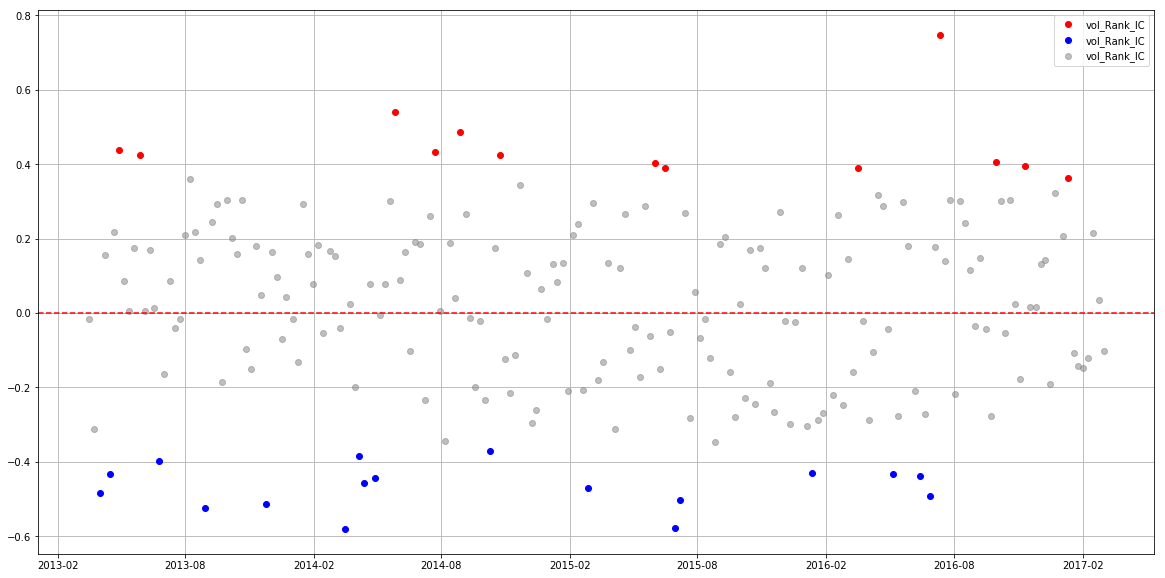

In [40]:
# IC plot of vol on weekly data
plt.figure(figsize=(20,10))
x11 = weekly_IC.vol_pvalue[(weekly_IC.vol_pvalue < 0.05) & (weekly_IC.vol_Rank_IC >= 0)].index
y11 = weekly_IC.vol_Rank_IC[x11]
x12 = weekly_IC.vol_pvalue[(weekly_IC.vol_pvalue < 0.05) & (weekly_IC.vol_Rank_IC < 0)].index
y12 = weekly_IC.vol_Rank_IC[x12]
x2 = weekly_IC.vol_pvalue[weekly_IC.vol_pvalue >= 0.05].index
y2 = weekly_IC.vol_Rank_IC[x2]
print('Positive significant rate: ', len(x11)/weekly_IC.shape[0], 'Negative significant rate: ', len(x12)/weekly_IC.shape[0])
plt.plot(y11, 'o', color='red')
plt.plot(y12, 'o', color='blue')
plt.plot(y2, 'o', alpha=0.5, label='vol_Rank_IC', color='grey')
#plt.plot(range(200), [0 for i in range(200)], 'r--')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Positive significant rate:  0.16326530612244897 Negative significant rate:  0.02040816326530612


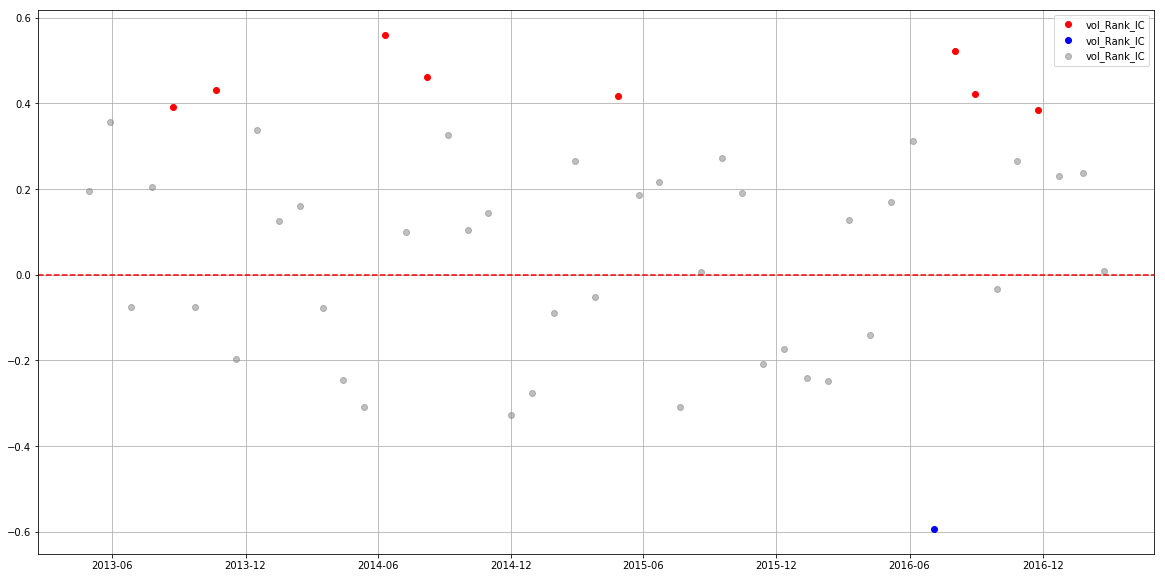

In [41]:
# IC plot of vol on monthly data
plt.figure(figsize=(20,10))
x11 = monthly_IC.vol_pvalue[(monthly_IC.vol_pvalue < 0.05) & (monthly_IC.vol_Rank_IC >= 0)].index
y11 = monthly_IC.vol_Rank_IC[x11]
x12 = monthly_IC.vol_pvalue[(monthly_IC.vol_pvalue < 0.05) & (monthly_IC.vol_Rank_IC < 0)].index
y12 = monthly_IC.vol_Rank_IC[x12]
x2 = monthly_IC.vol_pvalue[monthly_IC.vol_pvalue >= 0.05].index
y2 = monthly_IC.vol_Rank_IC[x2]
print('Positive significant rate: ', len(x11)/monthly_IC.shape[0], 'Negative significant rate: ', len(x12)/monthly_IC.shape[0])
plt.plot(y11, 'o', color='red')
plt.plot(y12, 'o', color='blue')
plt.plot(y2, 'o', alpha=0.5, label='vol_Rank_IC', color='grey')
#plt.plot(range(200), [0 for i in range(200)], 'r--')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Positive significant rate:  0.04 Negative significant rate:  0.06


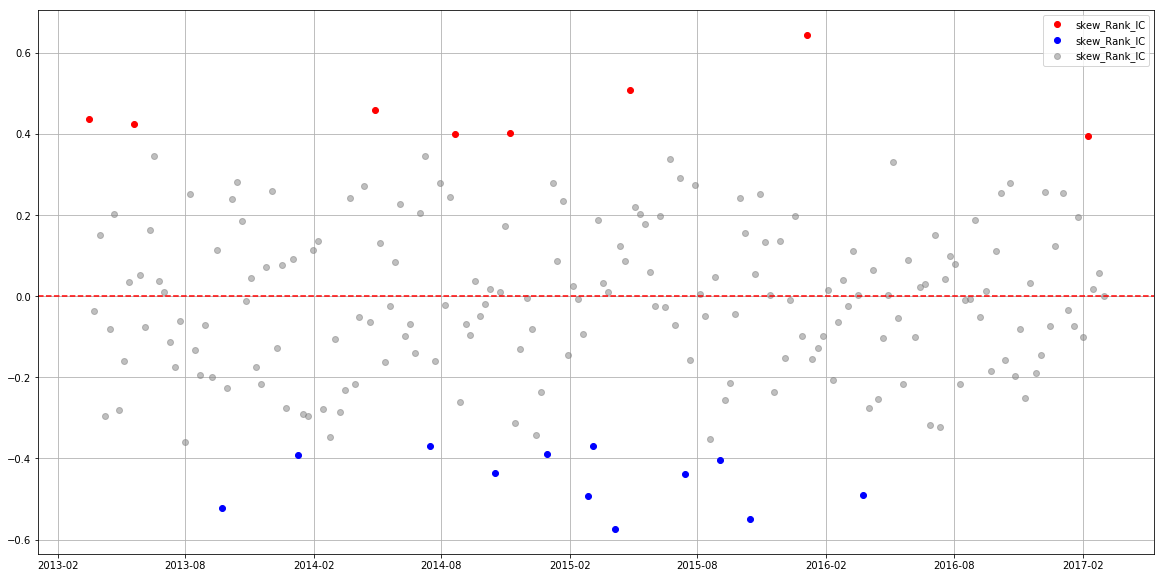

In [42]:
# IC plot of skew on weekly data
plt.figure(figsize=(20,10))
x11 = weekly_IC.skew_pvalue[(weekly_IC.skew_pvalue < 0.05) & (weekly_IC.skew_Rank_IC >= 0)].index
y11 = weekly_IC.skew_Rank_IC[x11]
x12 = weekly_IC.skew_pvalue[(weekly_IC.skew_pvalue < 0.05) & (weekly_IC.skew_Rank_IC < 0)].index
y12 = weekly_IC.skew_Rank_IC[x12]
x2 = weekly_IC.skew_pvalue[weekly_IC.skew_pvalue >= 0.05].index
y2 = weekly_IC.skew_Rank_IC[x2]
print('Positive significant rate: ', len(x11)/weekly_IC.shape[0], 'Negative significant rate: ', len(x12)/weekly_IC.shape[0])
plt.plot(y11, 'o', color='red')
plt.plot(y12, 'o', color='blue')
plt.plot(y2, 'o', alpha=0.5, label='skew_Rank_IC', color='grey')
#plt.plot(range(201), [0 for i in range(201)], 'r--')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Positive significant rate:  0.02040816326530612 Negative significant rate:  0.061224489795918366


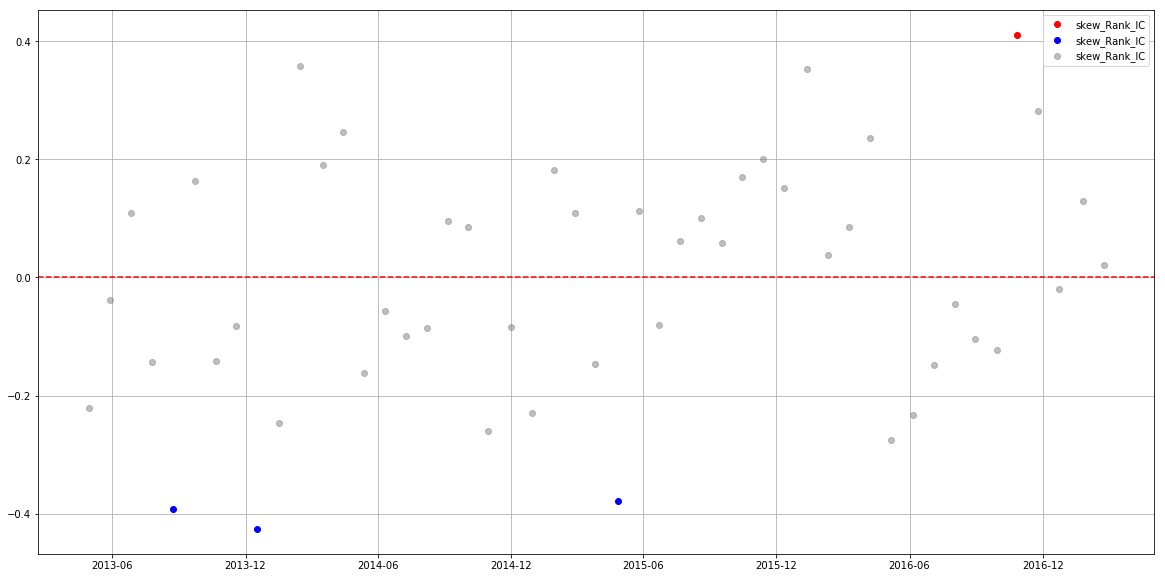

In [43]:
# IC plot of skew on monthly data
plt.figure(figsize=(20,10))
x11 = monthly_IC.skew_pvalue[(monthly_IC.skew_pvalue < 0.05) & (monthly_IC.skew_Rank_IC >= 0)].index
y11 = monthly_IC.skew_Rank_IC[x11]
x12 = monthly_IC.skew_pvalue[(monthly_IC.skew_pvalue < 0.05) & (monthly_IC.skew_Rank_IC < 0)].index
y12 = monthly_IC.skew_Rank_IC[x12]
x2 = monthly_IC.skew_pvalue[monthly_IC.skew_pvalue >= 0.05].index
y2 = monthly_IC.skew_Rank_IC[x2]
print('Positive significant rate: ', len(x11)/monthly_IC.shape[0], 'Negative significant rate: ', len(x12)/monthly_IC.shape[0])
plt.plot(y11, 'o', color='red')
plt.plot(y12, 'o', color='blue')
plt.plot(y2, 'o', alpha=0.5, label='skew_Rank_IC', color='grey')
#plt.plot(range(201), [0 for i in range(201)], 'r--')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Positive significant rate:  0.05 Negative significant rate:  0.085


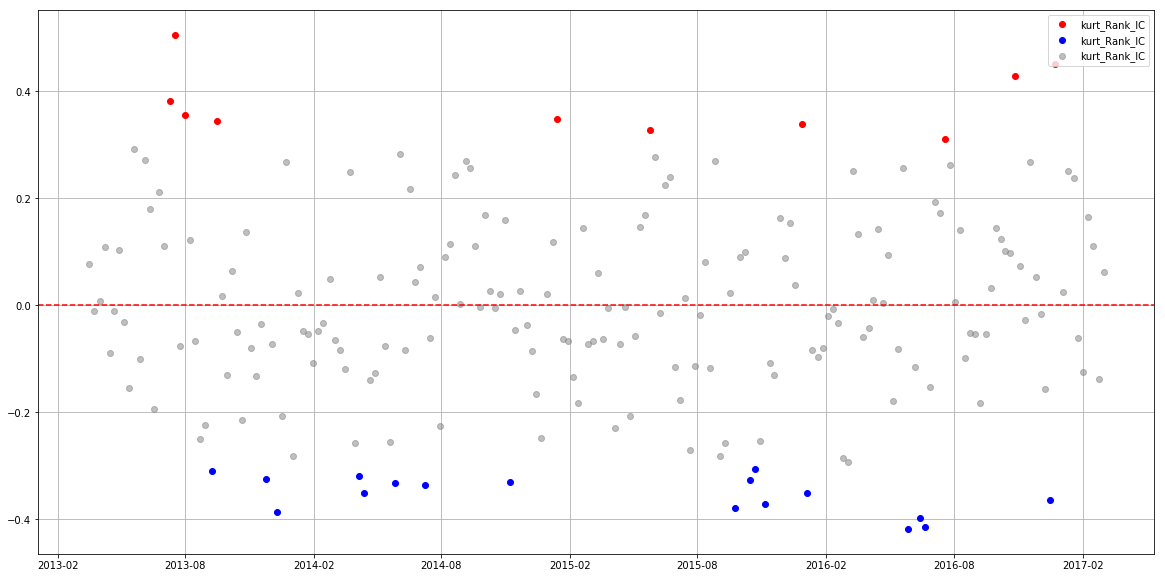

In [44]:
# IC plot of kurt on weekly data
plt.figure(figsize=(20,10))
x11 = weekly_IC.kurt_pvalue[(weekly_IC.kurt_pvalue < 0.1) & (weekly_IC.kurt_Rank_IC >= 0)].index
y11 = weekly_IC.kurt_Rank_IC[x11]
x12 = weekly_IC.kurt_pvalue[(weekly_IC.kurt_pvalue < 0.1) & (weekly_IC.kurt_Rank_IC < 0)].index
y12 = weekly_IC.kurt_Rank_IC[x12]
x2 = weekly_IC.kurt_pvalue[weekly_IC.kurt_pvalue >= 0.1].index
y2 = weekly_IC.kurt_Rank_IC[x2]
print('Positive significant rate: ', len(x11)/weekly_IC.shape[0], 'Negative significant rate: ', len(x12)/weekly_IC.shape[0])
plt.plot(x11, y11, 'o', color='red')
plt.plot(x12, y12, 'o', color='blue')
plt.plot(x2, y2, 'o', alpha=0.5, label='kurt_Rank_IC', color='grey')
#plt.plot(range(201), [0 for i in range(201)], 'r--')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Positive significant rate:  0.10204081632653061 Negative significant rate:  0.061224489795918366


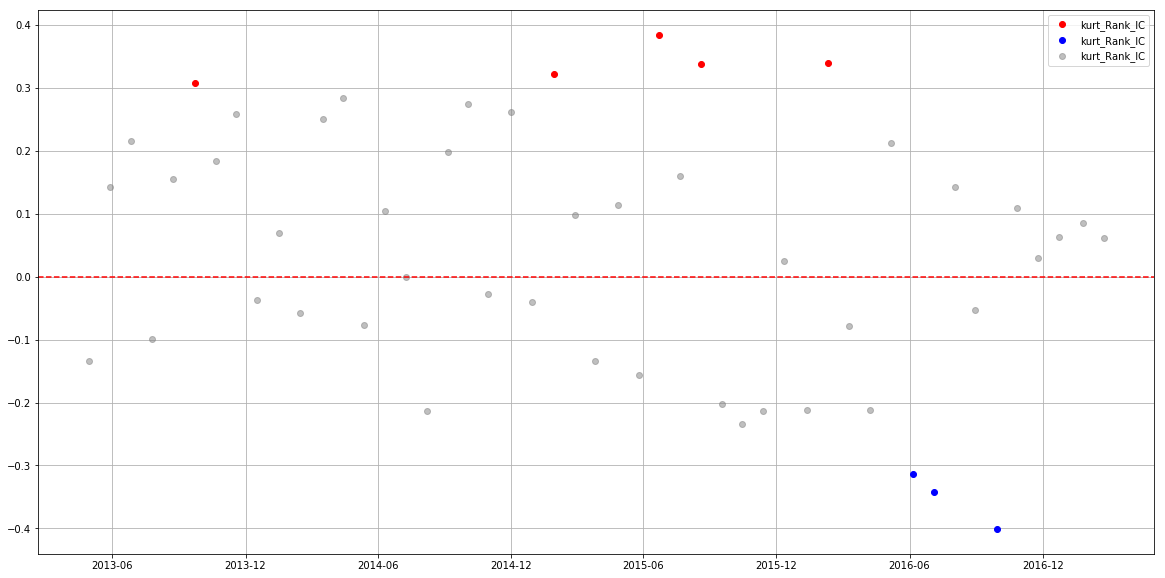

In [45]:
# IC plot of kurt on monthly data
plt.figure(figsize=(20,10))
x11 = monthly_IC.kurt_pvalue[(monthly_IC.kurt_pvalue < 0.1) & (monthly_IC.kurt_Rank_IC >= 0)].index
y11 = monthly_IC.kurt_Rank_IC[x11]
x12 = monthly_IC.kurt_pvalue[(monthly_IC.kurt_pvalue < 0.1) & (monthly_IC.kurt_Rank_IC < 0)].index
y12 = monthly_IC.kurt_Rank_IC[x12]
x2 = monthly_IC.kurt_pvalue[monthly_IC.kurt_pvalue >= 0.1].index
y2 = monthly_IC.kurt_Rank_IC[x2]
print('Positive significant rate: ', len(x11)/monthly_IC.shape[0], 'Negative significant rate: ', len(x12)/monthly_IC.shape[0])
plt.plot(x11, y11, 'o', color='red')
plt.plot(x12, y12, 'o', color='blue')
plt.plot(x2, y2, 'o', alpha=0.5, label='kurt_Rank_IC', color='grey')
#plt.plot(range(201), [0 for i in range(201)], 'r--')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [46]:
# stocks having significant beta1_vol
company_beta_pval[['vol_intercept','b_vol','vol_p_val']][company_beta_pval.vol_p_val <= 0.05]

,vol_intercept,b_vol,vol_p_val
2,0.071418,-0.427219,0.020926
4,0.055381,-0.347703,0.039734
6,-0.074692,0.423960,0.007181
10,-0.034438,0.188416,0.012714
14,0.044741,-0.380838,0.008319
35,0.046061,-0.329972,0.027715
50,0.038091,-0.420892,0.000522
52,0.033307,-0.141098,0.027226
60,-0.015709,0.276599,0.002978
68,-0.032375,0.322526,0.018117


In [47]:
# stocks having significant beta1_vol
monthly_beta_pval[['vol_intercept','b_vol','vol_p_val']][company_beta_pval.vol_p_val <= 0.05]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,vol_intercept,b_vol,vol_p_val
2,0.019740,-0.282967,0.183503
4,-0.135781,0.797485,0.031006
6,-0.089223,0.735814,0.020363
10,-0.053410,0.365231,0.400863
14,-0.063268,0.612462,0.003361
35,0.008313,-0.223157,0.576510


In [48]:
# stocks having significant beta1_skew
company_beta_pval[['skew_intercept','b_skew','skew_p_val']][company_beta_pval.skew_p_val <0.05]

,skew_intercept,b_skew,skew_p_val
0,-0.001965,0.032780,0.000227
26,0.004189,-0.025519,0.001583
29,0.017338,0.026155,0.010748
41,-0.005487,-0.023083,0.034103
49,0.016509,-0.022185,0.008746
67,0.009111,-0.030707,0.013080
72,0.013006,0.024474,0.015844
80,-0.013818,-0.044750,0.026369
88,-0.035045,-0.027279,0.025097
90,0.006547,-0.012826,0.045268


In [49]:
# stocks having significant beta1_skew
monthly_beta_pval[['skew_intercept','b_skew','skew_p_val']][company_beta_pval.skew_p_val <= 0.05]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,skew_intercept,b_skew,skew_p_val
0,0.031448,-0.069201,0.128663
26,0.003433,0.004140,0.881457
29,-0.020307,0.040031,0.446742
41,0.027394,-0.004765,0.921588


In [50]:
# Stocks having significant beta1_kurt
company_beta_pval[['kurt_intercept','b_kurt','kurt_p_val']][company_beta_pval.kurt_p_val <= 0.05]

,kurt_intercept,b_kurt,kurt_p_val
17,-0.055859,0.011542,0.003771
25,-0.055796,0.014679,0.011789
39,0.009256,0.003874,0.044080
51,-0.027884,0.006565,0.031241
60,0.038386,-0.004038,0.040885
103,0.029417,-0.003618,0.036375
118,0.029766,-0.007766,0.004044
124,0.025807,-0.002971,0.033397
127,0.015955,-0.008531,0.013412
142,-0.000892,-0.008157,0.041489


In [51]:
# Stocks having significant beta1_kurt
monthly_beta_pval[['kurt_intercept','b_kurt','kurt_p_val']][company_beta_pval.kurt_p_val <= 0.05]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,kurt_intercept,b_kurt,kurt_p_val
17,-0.018128,0.013201,0.064277
25,0.001988,0.004195,0.696647
39,0.121637,-0.019267,0.039264


In [52]:
company_beta_pval.shape

(200, 9)

In [53]:
monthly_beta_pval.shape

(49, 9)

In [54]:
company_beta_pval.mean()

vol_intercept     0.000855
b_vol             0.011892
vol_p_val         0.377512
skew_intercept    0.002484
b_skew           -0.001397
skew_p_val        0.446688
kurt_intercept    0.003865
b_kurt           -0.000266
kurt_p_val        0.457804
dtype: float64

In [55]:
monthly_beta_pval.mean()

vol_intercept    -0.011920
b_vol             0.158607
vol_p_val         0.317899
skew_intercept    0.010803
b_skew           -0.001318
skew_p_val        0.469226
kurt_intercept   -0.001543
b_kurt            0.002377
kurt_p_val        0.475146
dtype: float64

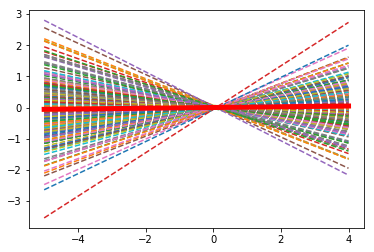

In [56]:
# Linear regression of return on vol
x = np.arange(-5,5)
for row in range(1, company_beta_pval.shape[0]):
    plt.plot(x, company_beta_pval.vol_intercept[row] + x*company_beta_pval.b_vol[row], '--')
plt.plot(x, company_beta_pval.vol_intercept.mean() + x*company_beta_pval.b_vol.mean(), color = 'red', lw = 5)
plt.show()

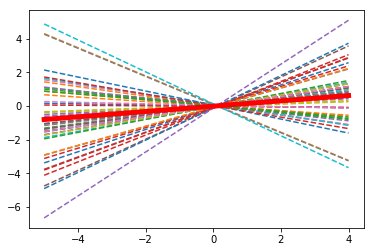

In [57]:
# Linear regression of return on vol
x = np.arange(-5,5)
for row in range(1, monthly_beta_pval.shape[0]):
    plt.plot(x, monthly_beta_pval.vol_intercept[row] + x*monthly_beta_pval.b_vol[row], '--')
plt.plot(x, monthly_beta_pval.vol_intercept.mean() + x*monthly_beta_pval.b_vol.mean(), color = 'red', lw = 5)
plt.show()

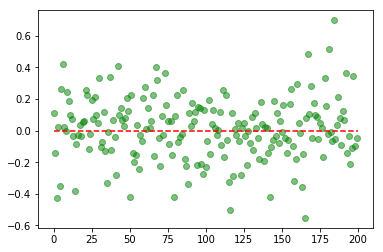

In [58]:
plt.plot(company_beta_pval.b_vol, 'o', alpha = 0.5, color = 'green')
plt.plot(range(201), [0 for i in range(201)], 'r--')

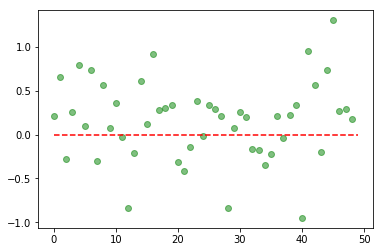

In [59]:
plt.plot(monthly_beta_pval.b_vol, 'o', alpha = 0.5, color = 'green')
plt.plot(range(50), [0 for i in range(50)], 'r--')

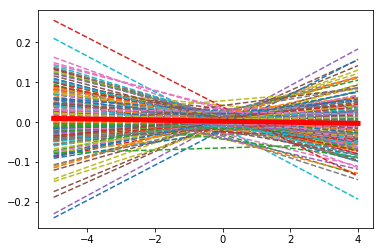

In [60]:
# Linear regression of return on skew
x = np.arange(-5,5)
for row in range(1, company_beta_pval.shape[0]):
    plt.plot(x, company_beta_pval.skew_intercept[row] + x*company_beta_pval.b_skew[row], '--')
plt.plot(x, company_beta_pval.skew_intercept.mean() + x*company_beta_pval.b_skew.mean(), color = 'red', lw = 5)
plt.show()

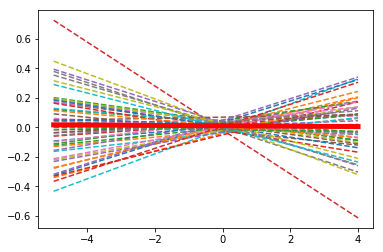

In [61]:
# Linear regression of return on skew
x = np.arange(-5,5)
for row in range(1, monthly_beta_pval.shape[0]):
    plt.plot(x, monthly_beta_pval.skew_intercept[row] + x*monthly_beta_pval.b_skew[row], '--')
plt.plot(x, monthly_beta_pval.skew_intercept.mean() + x*monthly_beta_pval.b_skew.mean(), color = 'red', lw = 5)
plt.show()

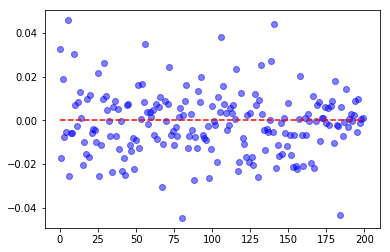

In [62]:
plt.plot(company_beta_pval.b_skew, 'o', alpha = 0.5, color = 'blue')
plt.plot(range(201), [0 for i in range(201)], 'r--')

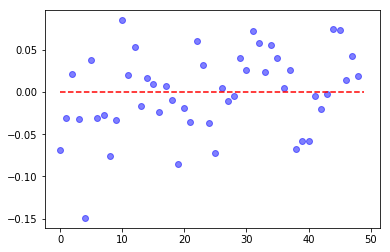

In [63]:
plt.plot(monthly_beta_pval.b_skew, 'o', alpha = 0.5, color = 'blue')
plt.plot(range(50), [0 for i in range(50)], 'r--')

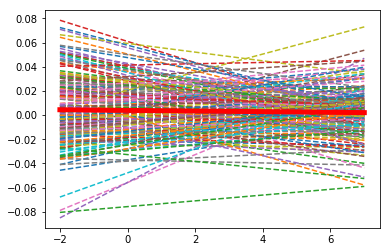

In [64]:
# Linear regression of return on kurt
x = np.arange(-2, 8)
for row in range(1, company_beta_pval.shape[0]):
    plt.plot(x, company_beta_pval.kurt_intercept[row] + x*company_beta_pval.b_kurt[row], '--')
plt.plot(x, company_beta_pval.kurt_intercept.mean() + x*company_beta_pval.b_kurt.mean(), color = 'red', lw = 5)
plt.show()

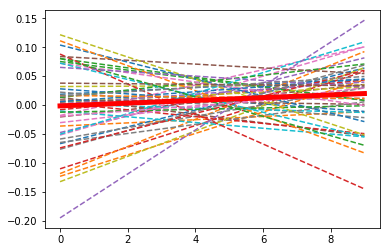

In [65]:
# Linear regression of return on kurt
x = np.arange(0, 10)
for row in range(1, monthly_beta_pval.shape[0]):
    plt.plot(x, monthly_beta_pval.kurt_intercept[row] + x*monthly_beta_pval.b_kurt[row], '--')
plt.plot(x, monthly_beta_pval.kurt_intercept.mean() + x*monthly_beta_pval.b_kurt.mean(), color = 'red', lw = 5)
plt.show()

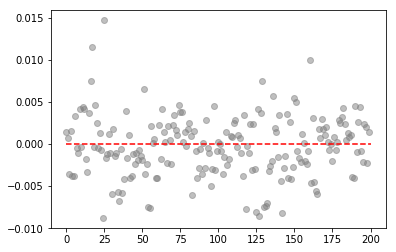

In [66]:
plt.plot(company_beta_pval.b_kurt, 'o', alpha = 0.5, color = 'grey')
plt.plot(range(201), [0 for i in range(201)], 'r--')

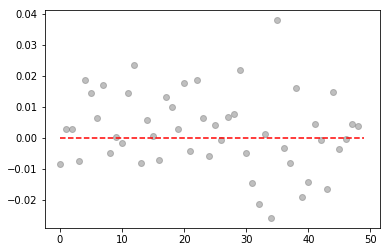

In [67]:
plt.plot(monthly_beta_pval.b_kurt, 'o', alpha = 0.5, color = 'grey')
plt.plot(range(50), [0 for i in range(50)], 'r--')

In [68]:
# return_by_group_vol
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_vol = pd.DataFrame(columns = group_name)
tmp_list = []
for week in range(total_week-1):
    vol_this_week = sorted([(com, weekly_data[com].RVol[week]) for com in weekly_data.keys()], key = lambda x: x[1])
    #print (vol_this_week)
    group_return_list = []
    for i in range(len(group_name)):
        cur_group, _ = zip(*vol_this_week[n_stock_grp*i : n_stock_grp*i+n_stock_grp])
        r_ = []
        for com in cur_group:
            r_.append(weekly_data[com].WR[week+1])
        group_return_list.append(np.median(r_))
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_vol = return_by_group_vol.append(tmp_list)
return_by_group_vol.index = weekly_data['AAPL'].index[1:]

In [69]:
# return_by_group_vol_monthly
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_vol_monthly = pd.DataFrame(columns = group_name)
tmp_list = []
for month in range(total_month-1):
    vol_this_month = sorted([(com, monthly_data[com].RVol[month]) for com in monthly_data.keys()], key = lambda x: x[1])
    #print (vol_this_month)
    group_return_list = []
    for i in range(len(group_name)):
        cur_group, _ = zip(*vol_this_month[n_stock_grp*i : n_stock_grp*i+n_stock_grp])
        r_ = []
        for com in cur_group:
            r_.append(monthly_data[com].MR[month+1])
        group_return_list.append(np.median(r_))
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_vol_monthly = return_by_group_vol_monthly.append(tmp_list)
return_by_group_vol_monthly.index = monthly_data['AAPL'].index[1:]

In [70]:
return_by_group_vol.sum()

group1    0.476444
group2    0.543917
group3    0.559507
dtype: float64

In [71]:
return_by_group_vol_monthly.sum()

group1    0.339007
group2    0.427324
group3    0.727851
dtype: float64

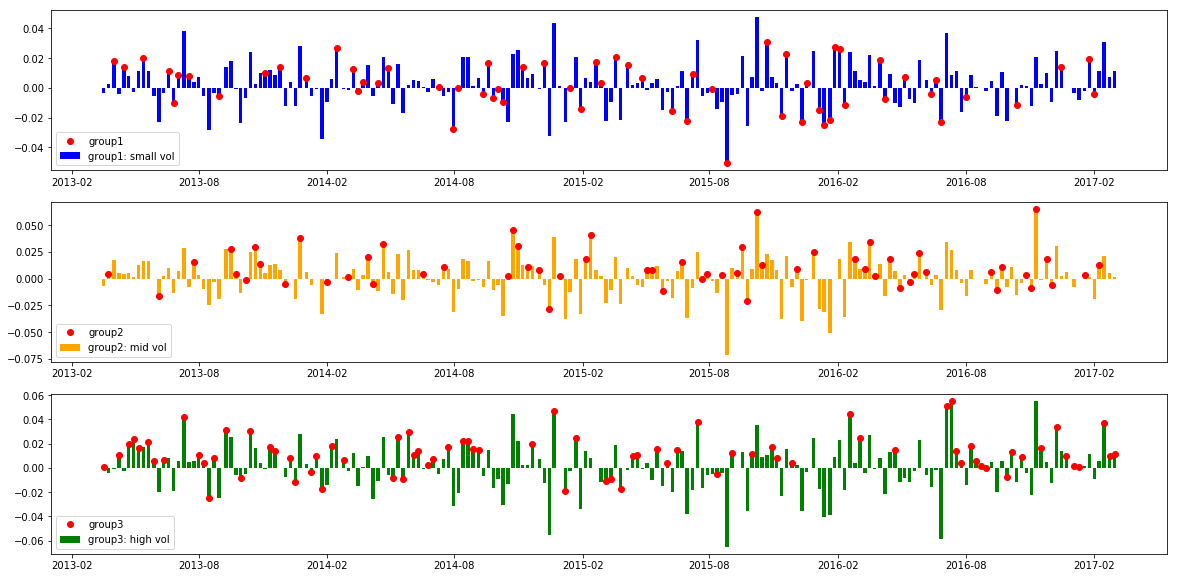

group1 win rate:  0.305 
 group2 win rate:  0.3 
 group3 win rate:  0.395


In [72]:
vol_max = return_by_group_vol.idxmax(axis = 1)
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.bar(return_by_group_vol.group1.index, return_by_group_vol.group1, label = 'group1: small vol', width = 5, color = 'blue')
plt.plot(return_by_group_vol.group1[vol_max[vol_max == 'group1'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(312)
plt.bar(return_by_group_vol.group2.index, return_by_group_vol.group2, label = 'group2: mid vol', width = 5, color = 'orange')
plt.plot(return_by_group_vol.group2[vol_max[vol_max == 'group2'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(313)
plt.bar(return_by_group_vol.group3.index, return_by_group_vol.group3, label = 'group3: high vol', width = 5, color = 'green')
plt.plot(return_by_group_vol.group3[vol_max[vol_max == 'group3'].index], 'ro')
#plt.bar(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50], alpha = 0.5, label = 'DJIA', lw = 4)
plt.legend(loc = 'lower left')
plt.show()
print ('group1 win rate: ', len(vol_max[vol_max == 'group1'])/float(len(vol_max)),'\n',\
       'group2 win rate: ', len(vol_max[vol_max == 'group2'])/float(len(vol_max)), '\n',\
       'group3 win rate: ', len(vol_max[vol_max == 'group3'])/float(len(vol_max)))

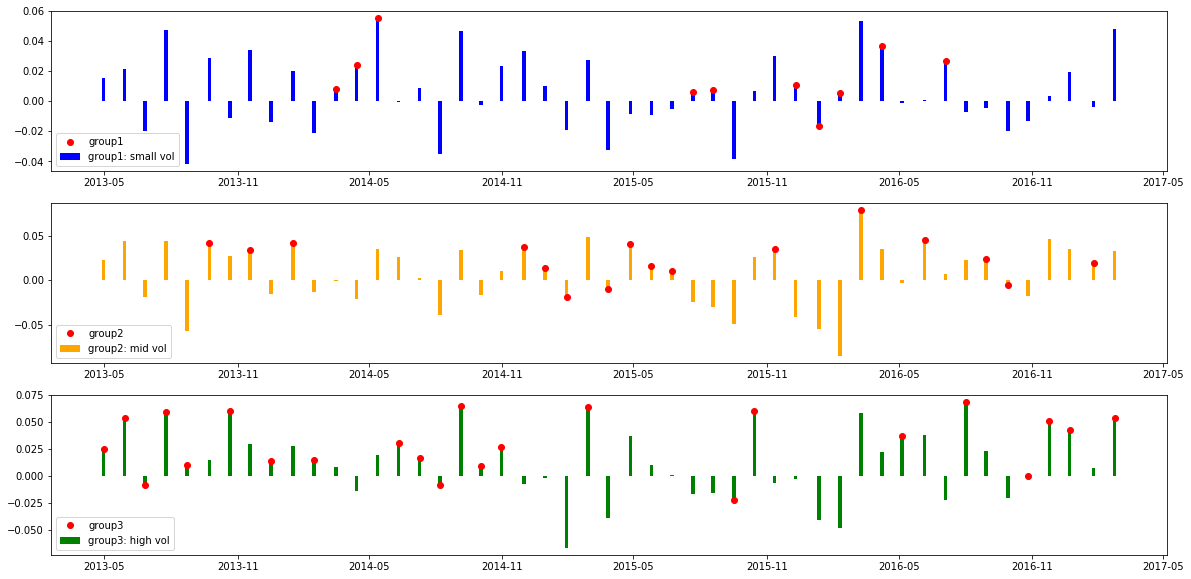

group1 win rate:  0.20408163265306123 
 group2 win rate:  0.32653061224489793 
 group3 win rate:  0.46938775510204084


In [73]:
vol_max = return_by_group_vol_monthly.idxmax(axis = 1)
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.bar(return_by_group_vol_monthly.group1.index, return_by_group_vol_monthly.group1, label = 'group1: small vol', width = 5, color = 'blue')
plt.plot(return_by_group_vol_monthly.group1[vol_max[vol_max == 'group1'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(312)
plt.bar(return_by_group_vol_monthly.group2.index, return_by_group_vol_monthly.group2, label = 'group2: mid vol', width = 5, color = 'orange')
plt.plot(return_by_group_vol_monthly.group2[vol_max[vol_max == 'group2'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(313)
plt.bar(return_by_group_vol_monthly.group3.index, return_by_group_vol_monthly.group3, label = 'group3: high vol', width = 5, color = 'green')
plt.plot(return_by_group_vol_monthly.group3[vol_max[vol_max == 'group3'].index], 'ro')
#plt.bar(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50], alpha = 0.5, label = 'DJIA', lw = 4)
plt.legend(loc = 'lower left')
plt.show()
print ('group1 win rate: ', len(vol_max[vol_max == 'group1'])/float(len(vol_max)),'\n',\
       'group2 win rate: ', len(vol_max[vol_max == 'group2'])/float(len(vol_max)), '\n',\
       'group3 win rate: ', len(vol_max[vol_max == 'group3'])/float(len(vol_max)))

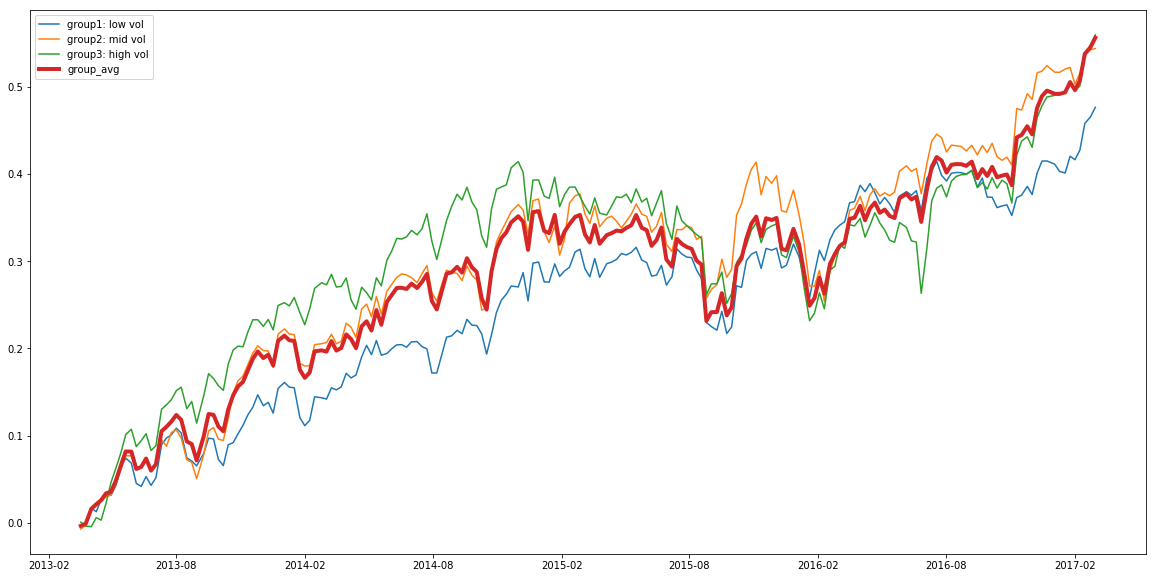

In [74]:
plt.figure(figsize=(20,10))
plt.plot(return_by_group_vol.group1.index, return_by_group_vol.group1.cumsum(), label = 'group1: low vol')
plt.plot(return_by_group_vol.group2.index, return_by_group_vol.group2.cumsum(), label = 'group2: mid vol')
plt.plot(return_by_group_vol.group3.index, return_by_group_vol.group3.cumsum(), label = 'group3: high vol')
plt.plot(return_by_group_vol.median(axis=1).cumsum(), label = 'group_avg', lw = 4)
plt.legend(loc = 'upper left')

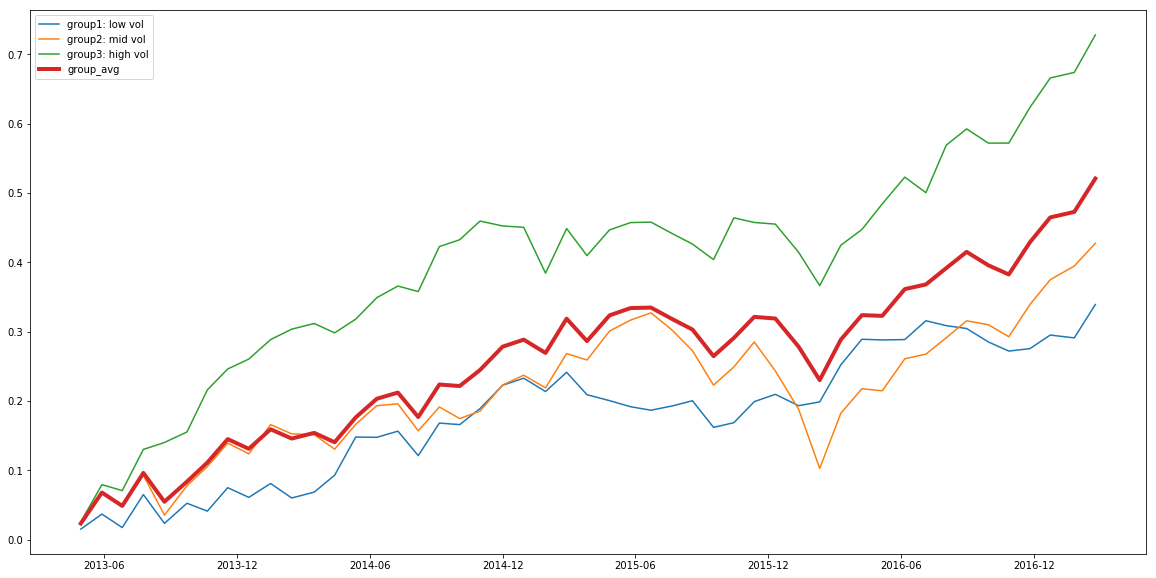

In [75]:
plt.figure(figsize=(20,10))
plt.plot(return_by_group_vol_monthly.group1.index, return_by_group_vol_monthly.group1.cumsum(), label = 'group1: low vol')
plt.plot(return_by_group_vol_monthly.group2.index, return_by_group_vol_monthly.group2.cumsum(), label = 'group2: mid vol')
plt.plot(return_by_group_vol_monthly.group3.index, return_by_group_vol_monthly.group3.cumsum(), label = 'group3: high vol')
plt.plot(return_by_group_vol_monthly.median(axis=1).cumsum(), label = 'group_avg', lw = 4)
plt.legend(loc = 'upper left')

In [76]:
# return_by_group_skew
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_skew = pd.DataFrame(columns = group_name)
tmp_list = []
for week in range(total_week-1):
    skew_this_week = sorted([(com, weekly_data[com].RSkew[week]) for com in weekly_data.keys()], key = lambda x: x[1])
    group_return_list = []
    for i in range(len(group_name)):
        cur_group, _ = zip(*skew_this_week[n_stock_grp*i : n_stock_grp*i+n_stock_grp])
        r_ = []
        for com in cur_group:
            r_.append(weekly_data[com].WR[week+1])
        group_return_list.append(np.median(r_))
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_skew = return_by_group_skew.append(tmp_list)
return_by_group_skew.index = weekly_data['AAPL'].index[1:]

In [77]:
# return_by_group_skew_monthly
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_skew_monthly = pd.DataFrame(columns = group_name)
tmp_list = []
for month in range(total_month-1):
    skew_this_month = sorted([(com, monthly_data[com].RSkew[month]) for com in monthly_data.keys()], key = lambda x: x[1])
    group_return_list = []
    for i in range(len(group_name)):
        cur_group, _ = zip(*skew_this_month[n_stock_grp*i : n_stock_grp*i+n_stock_grp])
        r_ = []
        for com in cur_group:
            r_.append(monthly_data[com].MR[month+1])
        group_return_list.append(np.median(r_))
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_skew_monthly = return_by_group_skew_monthly.append(tmp_list)
return_by_group_skew_monthly.index = monthly_data['AAPL'].index[1:]

In [78]:
return_by_group_skew.sum()

group1    0.505496
group2    0.554618
group3    0.422324
dtype: float64

In [79]:
return_by_group_skew_monthly.sum()

group1    0.567706
group2    0.374032
group3    0.526792
dtype: float64

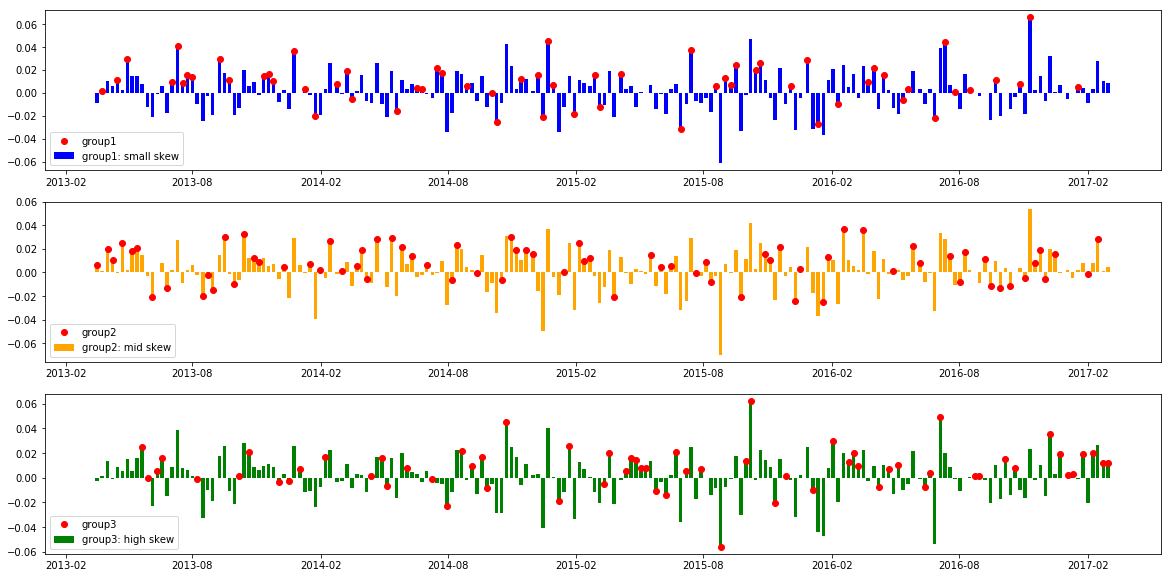

group1 win rate:  0.305 
 group2 win rate:  0.375 
 group3 win rate:  0.32


In [80]:
skew_max = return_by_group_skew.idxmax(axis = 1)
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.bar(return_by_group_skew.group1.index, return_by_group_skew.group1, label = 'group1: small skew', width = 5, color = 'blue')
plt.plot(return_by_group_skew.group1[skew_max[skew_max == 'group1'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(312)
plt.bar(return_by_group_skew.group2.index, return_by_group_skew.group2, label = 'group2: mid skew', width = 5, color = 'orange')
plt.plot(return_by_group_skew.group2[skew_max[skew_max == 'group2'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(313)
plt.bar(return_by_group_skew.group3.index, return_by_group_skew.group3, label = 'group3: high skew', width = 5, color = 'green')
plt.plot(return_by_group_skew.group3[skew_max[skew_max == 'group3'].index], 'ro')
#plt.bar(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50], alpha = 0.5, label = 'DJIA', lw = 4)
plt.legend(loc = 'lower left')
plt.show()
print ('group1 win rate: ', len(skew_max[skew_max == 'group1'])/float(len(skew_max)),'\n',\
       'group2 win rate: ', len(skew_max[skew_max == 'group2'])/float(len(skew_max)), '\n',\
       'group3 win rate: ', len(skew_max[skew_max == 'group3'])/float(len(skew_max)))

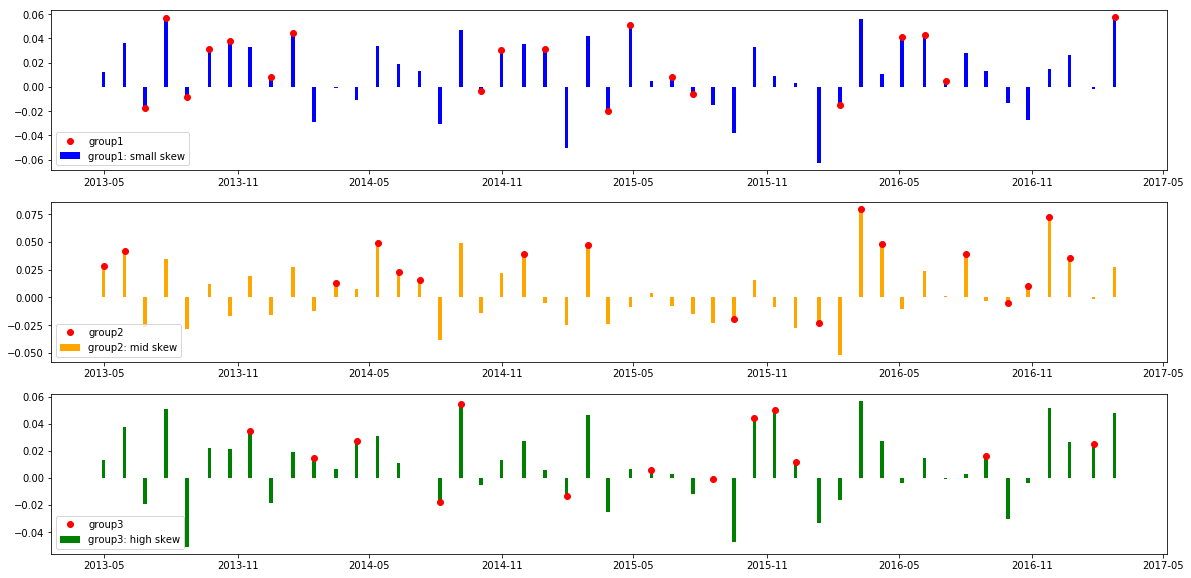

group1 win rate:  0.3877551020408163 
 group2 win rate:  0.3469387755102041 
 group3 win rate:  0.2653061224489796


In [81]:
skew_max = return_by_group_skew_monthly.idxmax(axis = 1)
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.bar(return_by_group_skew_monthly.group1.index, return_by_group_skew_monthly.group1, label = 'group1: small skew', width = 5, color = 'blue')
plt.plot(return_by_group_skew_monthly.group1[skew_max[skew_max == 'group1'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(312)
plt.bar(return_by_group_skew_monthly.group2.index, return_by_group_skew_monthly.group2, label = 'group2: mid skew', width = 5, color = 'orange')
plt.plot(return_by_group_skew_monthly.group2[skew_max[skew_max == 'group2'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(313)
plt.bar(return_by_group_skew_monthly.group3.index, return_by_group_skew_monthly.group3, label = 'group3: high skew', width = 5, color = 'green')
plt.plot(return_by_group_skew_monthly.group3[skew_max[skew_max == 'group3'].index], 'ro')
#plt.bar(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50], alpha = 0.5, label = 'DJIA', lw = 4)
plt.legend(loc = 'lower left')
plt.show()
print ('group1 win rate: ', len(skew_max[skew_max == 'group1'])/float(len(skew_max)),'\n',\
       'group2 win rate: ', len(skew_max[skew_max == 'group2'])/float(len(skew_max)), '\n',\
       'group3 win rate: ', len(skew_max[skew_max == 'group3'])/float(len(skew_max)))

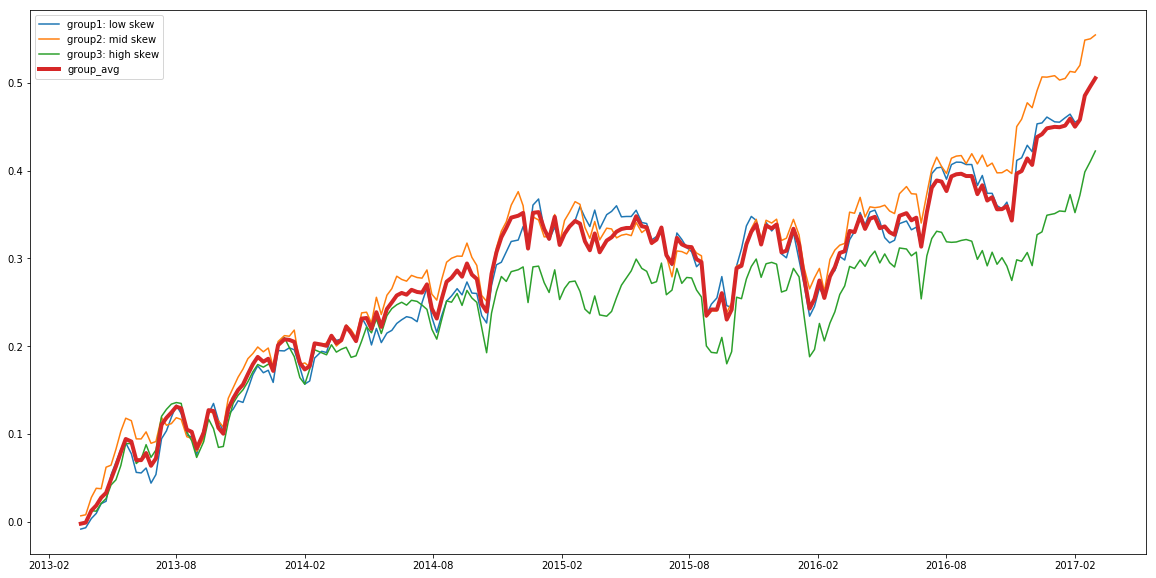

In [82]:
plt.figure(figsize = (20,10))
plt.plot(return_by_group_skew.group1.index, return_by_group_skew.group1.cumsum(), label = 'group1: low skew')
plt.plot(return_by_group_skew.group2.index, return_by_group_skew.group2.cumsum(), label = 'group2: mid skew')
plt.plot(return_by_group_skew.group3.index, return_by_group_skew.group3.cumsum(), label = 'group3: high skew')
plt.plot(return_by_group_skew.median(axis = 1).cumsum(), label = 'group_avg', lw = 4)
plt.legend(loc = 'upper left')

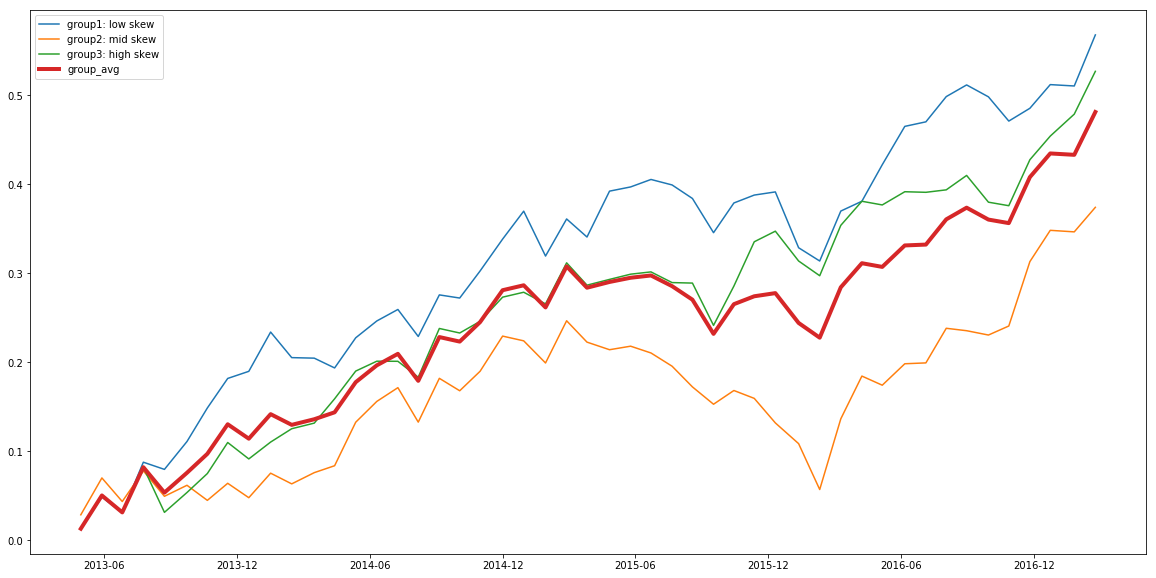

In [83]:
plt.figure(figsize = (20,10))
plt.plot(return_by_group_skew_monthly.group1.index, return_by_group_skew_monthly.group1.cumsum(), label = 'group1: low skew')
plt.plot(return_by_group_skew_monthly.group2.index, return_by_group_skew_monthly.group2.cumsum(), label = 'group2: mid skew')
plt.plot(return_by_group_skew_monthly.group3.index, return_by_group_skew_monthly.group3.cumsum(), label = 'group3: high skew')
plt.plot(return_by_group_skew_monthly.median(axis = 1).cumsum(), label = 'group_avg', lw = 4)
plt.legend(loc = 'upper left')

In [84]:
# return_by_group_kurt
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_kurt = pd.DataFrame(columns = group_name)
tmp_list = []
for week in range(total_week-1):
    kurt_this_week = sorted([(com, weekly_data[com].RKurt[week]) for com in weekly_data.keys()], key = lambda x: x[1])
    #print (vol_this_week)
    group_return_list = []
    for i in range(len(group_name)):
        cur_group, _ = zip(*kurt_this_week[n_stock_grp*i : n_stock_grp*i+n_stock_grp])
        r_ = []
        for com in cur_group:
            r_.append(weekly_data[com].WR[week+1])
        group_return_list.append(np.median(r_))
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_kurt = return_by_group_kurt.append(tmp_list)
return_by_group_kurt.index = weekly_data['AAPL'].index[1:]

In [85]:
# return_by_group_kurt_monthly
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_kurt_monthly = pd.DataFrame(columns = group_name)
tmp_list = []
for month in range(total_month-1):
    kurt_this_month = sorted([(com, monthly_data[com].RKurt[month]) for com in monthly_data.keys()], key = lambda x: x[1])
    #print (vol_this_month)
    group_return_list = []
    for i in range(len(group_name)):
        cur_group, _ = zip(*kurt_this_month[n_stock_grp*i : n_stock_grp*i+n_stock_grp])
        r_ = []
        for com in cur_group:
            r_.append(monthly_data[com].MR[month+1])
        group_return_list.append(np.median(r_))
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_kurt_monthly = return_by_group_kurt_monthly.append(tmp_list)
return_by_group_kurt_monthly.index = monthly_data['AAPL'].index[1:]

In [86]:
return_by_group_kurt.sum()

group1    0.543109
group2    0.615005
group3    0.414556
dtype: float64

In [87]:
return_by_group_kurt_monthly.sum()

group1    0.311681
group2    0.528041
group3    0.576497
dtype: float64

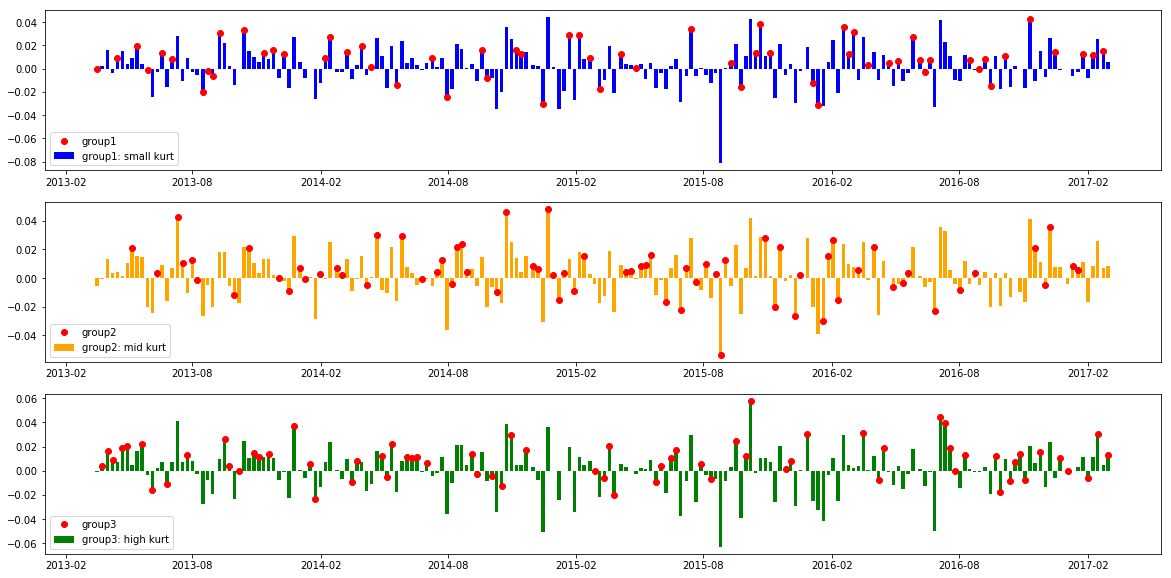

group1 win rate:  0.305 
 group2 win rate:  0.35 
 group3 win rate:  0.345


In [88]:
kurt_max = return_by_group_kurt.idxmax(axis = 1)
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.bar(return_by_group_kurt.group1.index, return_by_group_kurt.group1, label = 'group1: small kurt', width = 5, color = 'blue')
plt.plot(return_by_group_kurt.group1[kurt_max[kurt_max == 'group1'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(312)
plt.bar(return_by_group_kurt.group2.index, return_by_group_kurt.group2, label = 'group2: mid kurt', width = 5, color = 'orange')
plt.plot(return_by_group_kurt.group2[kurt_max[kurt_max == 'group2'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(313)
plt.bar(return_by_group_kurt.group3.index, return_by_group_kurt.group3, label = 'group3: high kurt', width = 5, color = 'green')
plt.plot(return_by_group_kurt.group3[kurt_max[kurt_max == 'group3'].index], 'ro')
#plt.bar(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50], alpha = 0.5, label = 'DJIA', lw = 4)
plt.legend(loc = 'lower left')
plt.show()
print ('group1 win rate: ', len(kurt_max[kurt_max == 'group1'])/float(len(kurt_max)),'\n',\
       'group2 win rate: ', len(kurt_max[kurt_max == 'group2'])/float(len(kurt_max)), '\n',\
       'group3 win rate: ', len(kurt_max[kurt_max == 'group3'])/float(len(kurt_max)))

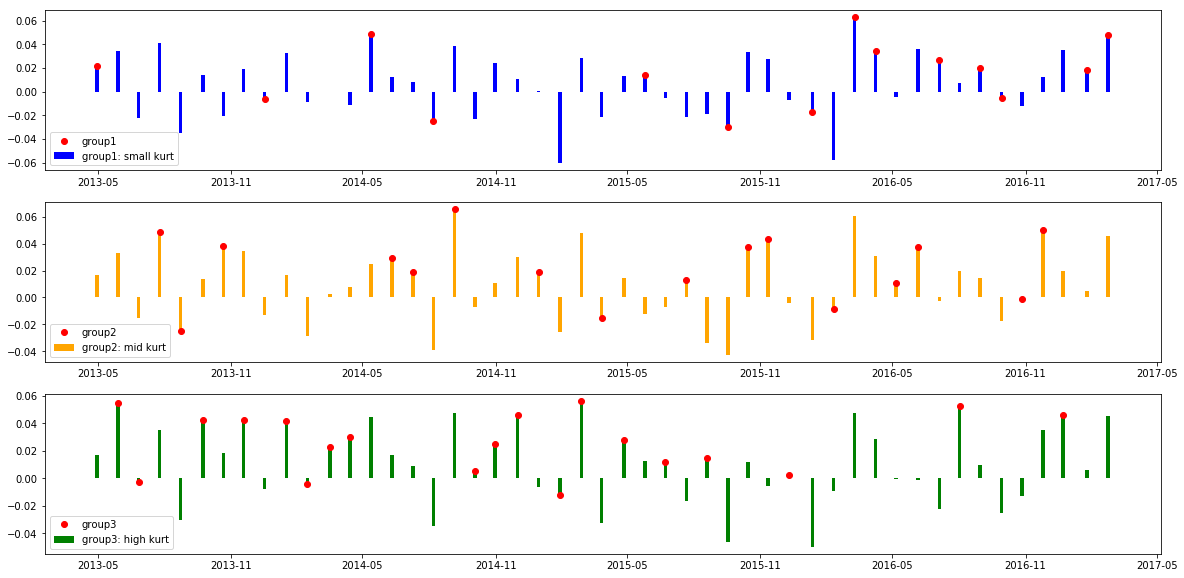

group1 win rate:  0.2857142857142857 
 group2 win rate:  0.32653061224489793 
 group3 win rate:  0.3877551020408163


In [89]:
kurt_max = return_by_group_kurt_monthly.idxmax(axis = 1)
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.bar(return_by_group_kurt_monthly.group1.index, return_by_group_kurt_monthly.group1, label = 'group1: small kurt', width = 5, color = 'blue')
plt.plot(return_by_group_kurt_monthly.group1[kurt_max[kurt_max == 'group1'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(312)
plt.bar(return_by_group_kurt_monthly.group2.index, return_by_group_kurt_monthly.group2, label = 'group2: mid kurt', width = 5, color = 'orange')
plt.plot(return_by_group_kurt_monthly.group2[kurt_max[kurt_max == 'group2'].index], 'ro')
plt.legend(loc = 'lower left')
plt.subplot(313)
plt.bar(return_by_group_kurt_monthly.group3.index, return_by_group_kurt_monthly.group3, label = 'group3: high kurt', width = 5, color = 'green')
plt.plot(return_by_group_kurt_monthly.group3[kurt_max[kurt_max == 'group3'].index], 'ro')
#plt.bar(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50], alpha = 0.5, label = 'DJIA', lw = 4)
plt.legend(loc = 'lower left')
plt.show()
print ('group1 win rate: ', len(kurt_max[kurt_max == 'group1'])/float(len(kurt_max)),'\n',\
       'group2 win rate: ', len(kurt_max[kurt_max == 'group2'])/float(len(kurt_max)), '\n',\
       'group3 win rate: ', len(kurt_max[kurt_max == 'group3'])/float(len(kurt_max)))

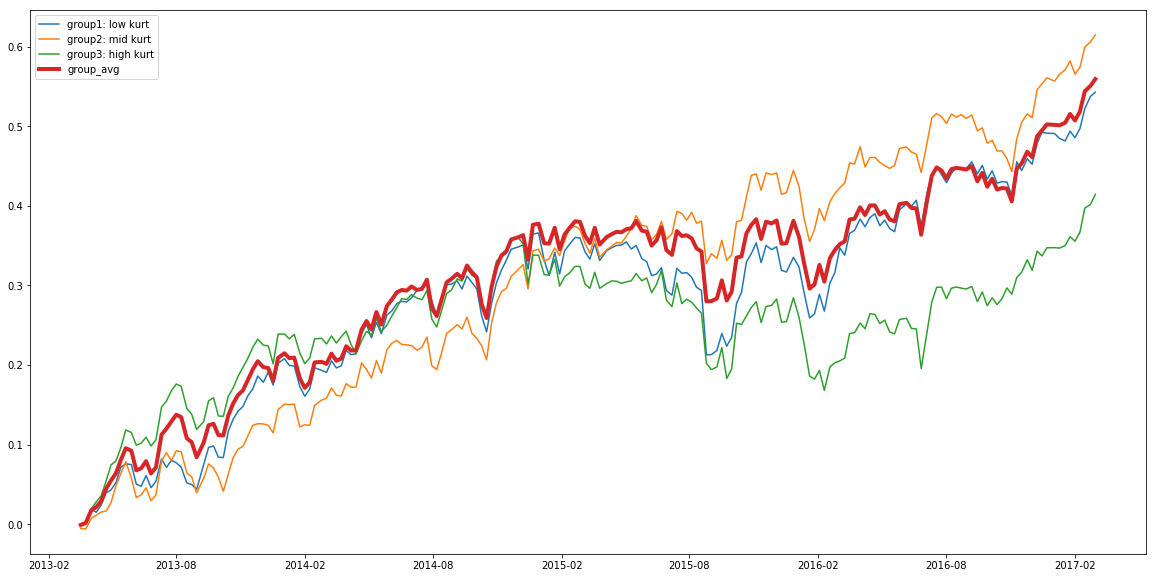

In [90]:
plt.figure(figsize=(20,10))
plt.plot(return_by_group_kurt.group1.cumsum(), label = 'group1: low kurt')
plt.plot(return_by_group_kurt.group2.cumsum(), label = 'group2: mid kurt')
plt.plot(return_by_group_kurt.group3.cumsum(), label = 'group3: high kurt')
#plt.plot(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50].cumsum(), label = 'DJIA', lw = 4)
#return_by_group_kurt['market'] = (return_by_group_kurt.group1 + return_by_group_kurt.group2 + return_by_group_kurt.group3)/3
plt.plot(return_by_group_kurt.median(axis = 1).cumsum(), label = 'group_avg', lw = 4)
plt.legend(loc = 'upper left')

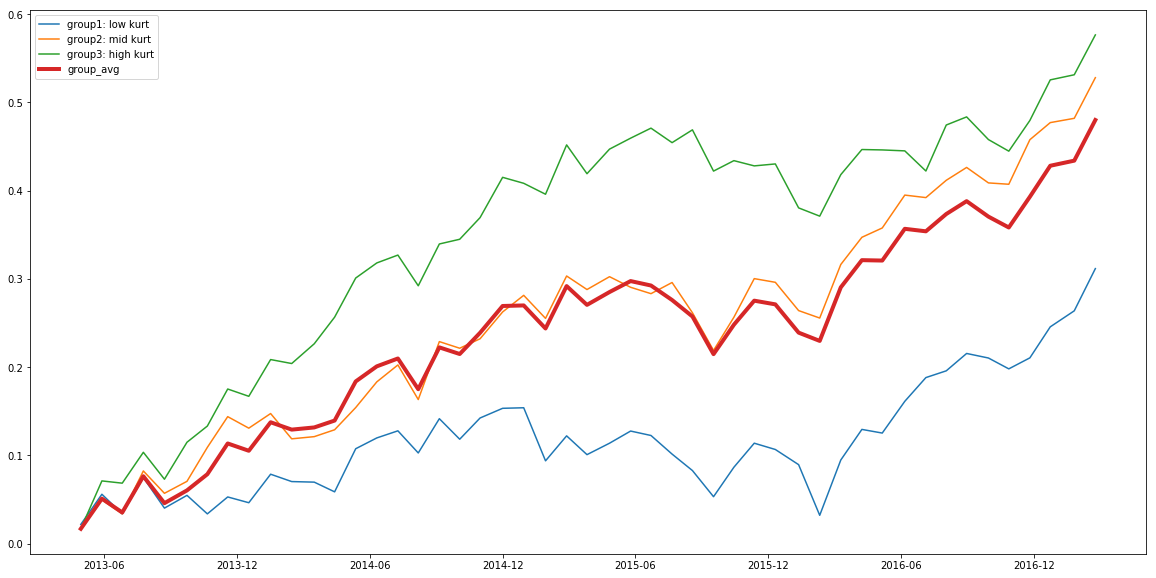

In [91]:
plt.figure(figsize=(20,10))
plt.plot(return_by_group_kurt_monthly.group1.cumsum(), label = 'group1: low kurt')
plt.plot(return_by_group_kurt_monthly.group2.cumsum(), label = 'group2: mid kurt')
plt.plot(return_by_group_kurt_monthly.group3.cumsum(), label = 'group3: high kurt')
#plt.plot(range(len(DJIA_weekly[:-50])), DJIA_weekly[:-50].cumsum(), label = 'DJIA', lw = 4)
#return_by_group_kurt_monthly['market'] = (return_by_group_kurt_monthly.group1 + return_by_group_kurt_monthly.group2 + return_by_group_kurt_monthly.group3)/3
plt.plot(return_by_group_kurt_monthly.median(axis = 1).cumsum(), label = 'group_avg', lw = 4)
plt.legend(loc = 'upper left')